# Collaborative Filtering V1: Using All Data from Merged WebEvent/Listings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Choose relevant working path
# %cd drive/My\ Drive/2020_Fall/'Captstone(297)'/data
%cd drive/My\ Drive/'Captstone(297)'/data

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1auWpfpINZvmJbl0I50kYmpS29bbnesqp/Captstone(297)/data


## Load in cleaned data from `M2_merge_and_clean_rexdata`

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [ ]:
merge_df2 = pd.read_csv("merged_user_data_rm_suspicious.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
merge_df2.shape

(728199, 63)

## Creating Custom Scoring Metric of WebEvent Data

In [ ]:
special_actions_level0 = ['scroll','pageview','ViewContent','view_item','drag','click']

# open-form (questions), (showing, showing-agent) = enter-flow = phone-click
# nav-tab (schools-and-comps), success(favorite), change(payment-calculator)
special_actions_level1 = ['open-form','enter-flow',  'nav-tab', 'change',
                          'success', 'Search', 'view_search_results', 'phone-click']
# 'nav' (insidere-details) = lead, submit = submit-success  (showing, showing-agent, buyer-lead-form)
special_actions_level2 = ['nav', 'lead', 'submit', 'submit-success','add_to_cart', 'InitiateCheckout',]
special_actions_level3 = ['Purchase','purchase']

In [ ]:
action_ct = merge_df2.action.value_counts()
total_ct = action_ct.sum()
level_weights = []
for i, curr_level in enumerate([special_actions_level0, special_actions_level1, 
                           special_actions_level2, special_actions_level3]):
  Lx_weight = 100*action_ct[curr_level].sum()/total_ct
  level_weights.append(Lx_weight)
  print("Level {0:d}: {1:.4f} %".format(i+1, Lx_weight))

Level 1: 99.3012 %
Level 2: 0.5997 %
Level 3: 0.0860 %
Level 4: 0.0132 %


In [ ]:
merge_df2.loc[merge_df2.action=='change'].category.value_counts()

payment-calculator    4135
Name: category, dtype: int64

### Extract user action info + calculate scores

In [ ]:
group = merge_df2.groupby(by=['ip', 'rexUrl']).agg(scroll_ct = ('action',lambda x: sum(x=="scroll")),
                                                   pageview_ct = ('action',lambda x: sum(x=="pageview")),
                                                   viewcontent_ct = ('action',lambda x: sum(x=='ViewContent')),
                                                   view_item_ct = ('action',lambda x: sum(x=='view_item')),
                                                   drag_ct = ('action',lambda x: sum(x=='drag')),
                                                   click_ct = ('action',lambda x: sum(x=='click')),
                                                   level0_ct = ('action', lambda x: sum(np.isin(x, special_actions_level0))),
                                                   level1_ct = ('action', lambda x: sum(np.isin(x, special_actions_level1))),
                                                   level2_ct = ('action', lambda x: sum(np.isin(x, special_actions_level2))),
                                                   level3_ct = ('action', lambda x: sum(np.isin(x, special_actions_level3))))
group.head()

scroll_ct  pageview_ct  ...  level2_ct  level3_ct
ip             rexUrl                                      ...                      
1.128.108.49   384-woodson-dr              6            2  ...          0          0
1.39.31.35     139-belmill-rd              3            1  ...          0          0
               552-mermaid-ave             5            1  ...          0          0
1.41.155.180   610-los-trancos-rd         17            1  ...          0          0
10.246.230.210 431-n-union-st             21            1  ...          0          0

[5 rows x 10 columns]

#### 2.2 Scoring rules
* cap at 6, if above 6 will be rounded to 6

>**new version**<br>
weight by action frequency and cap by 6

[old version]
1.   Level 0 - normal actions: weight 0.1 per ct
2.   Level 1 - show a bit interest actions: weight 1 per ct
3.   Level 2 - user asked for additional info: weight 2 per ct
4.   Level 3 - user click the purchase button: weight 3 per ct



In [ ]:
def calculate_score(row):
  curr_score = 0
  for i in range(4):
    curr_weight = np.clip(1/level_weights[i],0,6)
    curr_score += row[f'level{i}_ct']*curr_weight
  return min(6, curr_score)

# Based on Selina score rule
group['score'] = group.apply(lambda x: calculate_score(x), axis=1)

## input for CF model
cf_data = group.reset_index()[['ip', 'rexUrl','score']]
print("Input for CF model: ", cf_data.shape)
cf_data.head()

Input for CF model:  (33693, 3)


,ip,rexUrl,score
0,1.128.108.49,384-woodson-dr,0.120845
1,1.39.31.35,139-belmill-rd,0.060422
2,1.39.31.35,552-mermaid-ave,0.080563
3,1.41.155.180,610-los-trancos-rd,0.201408
4,10.246.230.210,431-n-union-st,0.241689


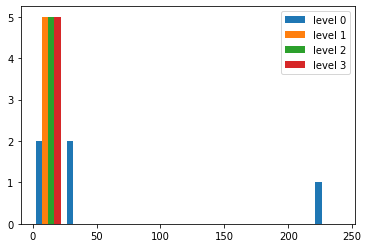

In [ ]:
high_score_df = group.loc[(group.score<=6) &(group.score>=1)].head()

plt.hist([high_score_df.level0_ct, high_score_df.level1_ct, high_score_df.level2_ct, high_score_df.level3_ct])
plt.legend(['level 0', 'level 1', 'level 2', 'level 3'])
plt.show()

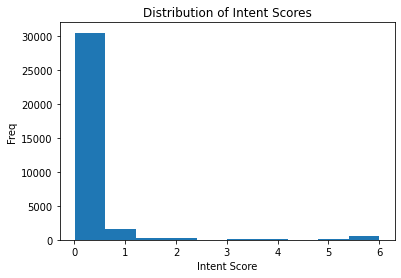

In [ ]:
plt.hist(cf_data.score)
plt.title('Distribution of Intent Scores')
plt.ylabel('Freq')
plt.xlabel('Intent Score')
plt.show()

### 2.3 Investigate number of houses observed per ip

In [ ]:
group2 = group.reset_index().groupby(by=['ip'])[['rexUrl']].count()
group2.head()

,rexUrl
ip,
1.128.108.49,1
1.39.31.35,2
1.41.155.180,1
10.246.230.210,1
10.70.33.53,1


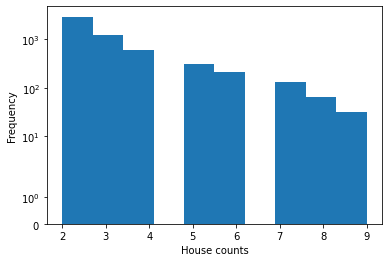

In [ ]:
url_ct = group2.rexUrl.values
plt.hist(url_ct[(url_ct<10)&(url_ct>1)], bins=10)
plt.yscale('symlog')
plt.xlabel("House counts")
plt.ylabel("Frequency")
plt.show()

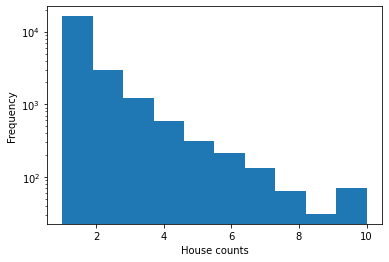

In [ ]:
plt.hist(np.clip(url_ct,0,10))
plt.yscale('log')
plt.xlabel("House counts")
plt.ylabel("Frequency")
plt.show()

In [ ]:
len(set(merge_df2['ip']))

21921

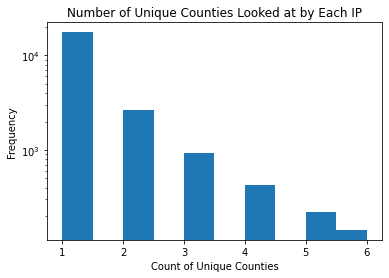

In [ ]:
counties_per_ip = merge_df2.groupby('ip').agg({'county':'nunique'})['county']
plt.hist(np.clip(counties_per_ip,0,10))
plt.yscale('log')
plt.title('Number of Unique Counties Looked at by Each IP')
plt.xlabel("Count of Unique Counties")
plt.ylabel("Frequency")
plt.show()

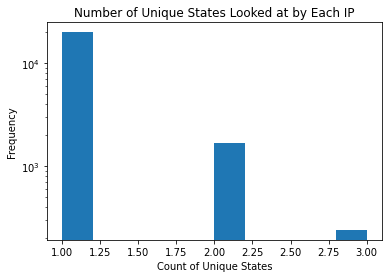

In [ ]:
states_per_ip = merge_df2.groupby('ip').agg({'state':'nunique'})['state']
plt.hist(np.clip(states_per_ip,0,10))
plt.yscale('log')
plt.title('Number of Unique States Looked at by Each IP')
plt.xlabel("Count of Unique States")
plt.ylabel("Frequency")
plt.show()

In [ ]:
len(states_per_ip[states_per_ip>10])

0

## 2.4 CF Model using Entire Dataset

>`Item-Item Collaborative Filtering`: "Users who liked this item also liked …"<br>
>`User-Item Collaborative Filtering`: "Users who are similar to you also liked …"

In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 284kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670965 sha256=1c8d472c7d9f4cb2a22ff8ed40a8924450df66725cbf27d9d09e8f27cbb38589
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
# https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0
from surprise import Reader, Dataset
from surprise import SVD
from surprise import NMF
from surprise import Dataset
from surprise import accuracy
import surprise


from surprise.model_selection import train_test_split
from surprise.model_selection import KFold


In [ ]:
# to load dataset from pandas df, we need `load_fromm_df` method in surprise lib

ratings_dict = {'itemID': list(cf_data.rexUrl),
                'userID': list(cf_data.ip),
                'rating': list(cf_data.score)}
df = pd.DataFrame(ratings_dict)
reader = Reader(rating_scale=(0, 6.0))

data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

## Simple K-Fold SVD

In [ ]:
# # sample random trainset and testset
# # test set is made of 25% of the ratings.
# trainset, testset = train_test_split(data, test_size=.25)

# # Use SVD algorithm.
# algo = SVD()

# # Train the algorithm on the trainset, and predict ratings for the testset
# algo.fit(trainset)
# predictions = algo.test(testset)

# # Then compute RMSE
# accuracy.rmse(predictions)

# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8887
RMSE: 0.8169
RMSE: 0.7833
RMSE: 0.8627
RMSE: 0.8489


---

## Analysis of Recommendations

In [ ]:
cf_data.loc[cf_data.rexUrl=="1006-e-59th-st-brooklyn"].head(1)

,ip,rexUrl,score
19,100.1.108.166,1006-e-59th-st-brooklyn,0.422956


In [ ]:
uid_test = '100.1.108.166'
iid_test = '1006-e-59th-st-brooklyn'

# get a prediction for specific users and items.
pred = algo.predict(uid_test, iid_test, r_ui=0.42, verbose=False)
pred.est

0.37726620208067585

### Function to return top recommendations for user

In [ ]:
def top_recs_for_user(ratings_df_in, uid_in, algo_in):
  unique_listings = set(ratings_df_in['itemID'])
  unseen_listings = unique_listings - set(ratings_df_in[ratings_df_in['userID']==uid_in]['itemID'])
  unseen_listings = list(unseen_listings)

  preds = []
  for listing in unseen_listings:
    preds.append(algo_in.predict(uid_in, listing, verbose=False).est)

  preds_df = pd.DataFrame({'iid': unseen_listings, 'pred_score': preds})
  preds_df.sort_values('pred_score', ascending=False,inplace=True)

  return preds_df

These are the top predictions

In [ ]:
top_recs_for_user(ratings_df_in=df, uid_in = uid_test, algo_in=algo).head(10)

,iid,pred_score
869,1335-calle-pecos,1.570673
1013,4232-upper-park-dr,1.247818
351,1742-stratford-cir,1.022544
1095,183-river-run-cir,0.992352
1050,6719-glen-mawr-ave,0.982111
269,521-sterling-falls-ave,0.930813
480,7140-foggy-mist-ave,0.921168
1497,630-cranes-way-apt-302,0.897232
1368,36164-darcy-pl,0.894252
1086,8219-andrus-dr,0.886195


Looking into where this person was looking for houses

In [ ]:
df[df['userID']==uid_test].sort_values('rating',ascending=False).head()

,itemID,userID,rating
20,12728-matanza-rd,100.1.108.166,0.584082
22,70-academy-ct,100.1.108.166,0.463237
19,1006-e-59th-st-brooklyn,100.1.108.166,0.422956
21,267-dumont-ave,100.1.108.166,0.362534


These listings are far from one another

Lets investigate how many markets people were looking at...

In [ ]:
user_searched = merge_df2[merge_df2['ip']==uid_test].copy()

In [ ]:
user_searched.groupby(['city','market','marketing_budget','sales'],dropna=False)['url'].count()

city        market  marketing_budget  sales
Bedminster  NJ      MEDIUM            NJ       46
Brooklyn    NY      MEDIUM            NY       78
San Diego   SD      MEDIUM            SD       58
Name: url, dtype: int64

In [ ]:
merge_df2[merge_df2['ip']==uid_test]['state'].unique()

array(['NY', 'NJ', 'CA'], dtype=object)

Why is this ip looking at so many different markets? Is this an issue? Can we not use ip?

In [ ]:
merge_df2[merge_df2['ip']==uid_test].head()

,id,event_stamp,action,category,ip,visitor_guid,url,city_name,country_code2,domain,eventAttributes,gclid,latitude_x,listingGuid,longitude_x,postal_code_x,propertyGuid,region_code,region_name,rexUrl,sessionGuid,uriStem,userGuid,Unnamed: 0,id_x,guid_x,address_line,city,state,postal_code_y,created_x,updated_x,id_y,guid_y,created_y,updated_y,address_id,bedrooms,county,full_baths,land_square_footage,latitude_y,living_square_feet,longitude_y,market,marketing_budget,marketing_status,on_mls,property_type,rex_url,sales,school_district_id,school_district_name,status,stories,timezone_id,total_baths,total_baths_calculated,year_built,addr_lower_x,rexurl,call_ct,buyer_call
344,109760942,2020-09-07 01:58:49.873000,drag,listing-map,100.1.108.166,68d829beaaa841ed8d47361df5f1727f,https://www.rexhomes.com/listing/1006-e-59th-s...,Somerset,US,www.rexhomes.com,NaN,NaN,40.5007,058d10169ebc42cba5edc6407a98563f,-74.5013,8873,NaN,NJ,New Jersey,1006-e-59th-st-brooklyn,414901f185fb4876a2d1b73307e133be,/listing/1006-e-59th-st-brooklyn,NaN,101052.0,102200.0,8e792d34094640988616b97a0d05b4e8,1006 E 59th St,Brooklyn,NY,11234.0,2020-06-01 20:20:51,2020-08-10 20:12:48.907000,103175.0,058d10169ebc42cba5edc6407a98563f,2020-06-01 20:20:50.532000,2020-09-10 22:00:06.238000,102200.0,7.0,Kings,NaN,2117.0,40.628463,3021.0,-73.919509,NY,MEDIUM,False,0.0,MULTI_FAMILY,1006-e-59th-st-brooklyn,NY,3620580.0,Nyc Geog District #22 - Brooklyn,IN_ESCROW,2.0,America/New_York,3.0,NaN,1965.0,1006 e 59th st,NaN,NaN,NaN
345,109760939,2020-09-07 01:58:49.638000,drag,listing-map,100.1.108.166,68d829beaaa841ed8d47361df5f1727f,https://www.rexhomes.com/listing/1006-e-59th-s...,Somerset,US,www.rexhomes.com,NaN,NaN,40.5007,058d10169ebc42cba5edc6407a98563f,-74.5013,8873,NaN,NJ,New Jersey,1006-e-59th-st-brooklyn,414901f185fb4876a2d1b73307e133be,/listing/1006-e-59th-st-brooklyn,NaN,101052.0,102200.0,8e792d34094640988616b97a0d05b4e8,1006 E 59th St,Brooklyn,NY,11234.0,2020-06-01 20:20:51,2020-08-10 20:12:48.907000,103175.0,058d10169ebc42cba5edc6407a98563f,2020-06-01 20:20:50.532000,2020-09-10 22:00:06.238000,102200.0,7.0,Kings,NaN,2117.0,40.628463,3021.0,-73.919509,NY,MEDIUM,False,0.0,MULTI_FAMILY,1006-e-59th-st-brooklyn,NY,3620580.0,Nyc Geog District #22 - Brooklyn,IN_ESCROW,2.0,America/New_York,3.0,NaN,1965.0,1006 e 59th st,NaN,NaN,NaN
346,109760940,2020-09-07 01:58:49.638000,drag,listing-map,100.1.108.166,68d829beaaa841ed8d47361df5f1727f,https://www.rexhomes.com/listing/1006-e-59th-s...,Somerset,US,www.rexhomes.com,NaN,NaN,40.5007,058d10169ebc42cba5edc6407a98563f,-74.5013,8873,NaN,NJ,New Jersey,1006-e-59th-st-brooklyn,414901f185fb4876a2d1b73307e133be,/listing/1006-e-59th-st-brooklyn,NaN,101052.0,102200.0,8e792d34094640988616b97a0d05b4e8,1006 E 59th St,Brooklyn,NY,11234.0,2020-06-01 20:20:51,2020-08-10 20:12:48.907000,103175.0,058d10169ebc42cba5edc6407a98563f,2020-06-01 20:20:50.532000,2020-09-10 22:00:06.238000,102200.0,7.0,Kings,NaN,2117.0,40.628463,3021.0,-73.919509,NY,MEDIUM,False,0.0,MULTI_FAMILY,1006-e-59th-st-brooklyn,NY,3620580.0,Nyc Geog District #22 - Brooklyn,IN_ESCROW,2.0,America/New_York,3.0,NaN,1965.0,1006 e 59th st,NaN,NaN,NaN
347,109760556,2020-09-07 01:57:20.501000,view_item,NaN,100.1.108.166,68d829beaaa841ed8d47361df5f1727f,https://www.rexhomes.com/listing/1006-e-59th-s...,Somerset,US,www.rexhomes.com,NaN,NaN,40.5007,058d10169ebc42cba5edc6407a98563f,-74.5013,8873,NaN,NJ,New Jersey,1006-e-59th-st-brooklyn,414901f185fb4876a2d1b73307e133be,/listing/1006-e-59th-st-brooklyn,NaN,101052.0,102200.0,8e792d34094640988616b97a0d05b4e8,1006 E 59th St,Brooklyn,NY,11234.0,2020-06-01 20:20:51,2020-08-10 20:12:48.907000,103175.0,058d10169ebc42cba5edc6407a98563f,2020-06-01 20:20:50.532000,2020-09-10 22:00:06.238000,102200.0,7.0,Kings,NaN,2117.0,40.628463,3021.0,-73.919509,NY,MEDIUM,False,0.0,MULTI_FAMILY,1006-e-59th-st-brooklyn,NY,3620580.0,Nyc Geog District #22 - Brooklyn,IN_ESCROW,2.0,America/New_York,3.0,NaN,1965.0,1006 e 59th st,NaN,NaN,NaN
348,109762140,2020-09-07 02:02:38.359000,scroll

### Recommendations within same region that they were browsing
Now, lets subset recs to just within geographic region


In [ ]:
def top_recs_for_user_county(rating_df, merge_df, uid_in, algo_in):

  users_counties = merge_df[merge_df['ip']==uid_in]['county'].unique()
  listings_in_county = set(merge_df[merge_df['county'].isin(users_counties)]['rexUrl'])

  unseen_listings = listings_in_county - set(rating_df[rating_df['userID']==uid_in]['itemID'])
  unseen_listings = list(unseen_listings)

  preds = []
  for listing in unseen_listings:
    preds.append(algo_in.predict(uid_in, listing, verbose=False).est)

  preds_df = pd.DataFrame({'iid': unseen_listings, 'pred_score': preds})
  preds_df.sort_values('pred_score', ascending=False,inplace=True)

  return preds_df

What they were recommended in the same regions

In [ ]:
merge_df2[merge_df2['ip']=='100.1.158.161']['county'].unique()

array(['Kings', 'Middlesex', 'Pasco'], dtype=object)

In [ ]:
top_recs_for_user_county(rating_df=df, merge_df = merge_df2, uid_in = '100.1.158.161', algo_in=algo).head()

,iid,pred_score
4,713-stony-brook-way,0.767693
29,101-flint-st,0.664879
16,267-dumont-ave,0.664158
1,8-rose-pt-apt-8,0.591633
20,3462-fulton-st,0.582429


What they "rated"

In [ ]:
df[df['userID']=='100.1.158.161'].sort_values('rating',ascending=False).head()

,itemID,userID,rating
35,19081-andrea-lynn-ln,100.1.158.161,0.966756
36,302-jacob-ct,100.1.158.161,0.866052
34,1006-e-59th-st-brooklyn,100.1.158.161,0.644504


## Overall, we see a mismatch between recommendations and regions where the user seemed to have been searching...

### We will now try subsetting the CF model to data from one region. (See `CollabFilter_v1_NJSubset.ipynb`)